# Исследование рынка заведений общественного питания Москвы

Мы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Для реализации проекта решено обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

Необходимо подготовить исследование рынка. У нас есть открытые данные о заведениях общественного питания в Москве.

В процессе выполнения предстоит выполнить следующие действия:
- загрузить данные, ознакомиться с ними
- обработать пропуски и дубликаты при их наличии
- рассмотрим объекты общественного питания по видам
- рассмотрим местонахождение объектов на территории Москвы
- на основе рассмотренных данных сделаем выводы и рекомендации
- подготовим презентацию исследования для инвесторов.

## Изучение данных

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px 
from plotly import graph_objects as go
from io import BytesIO
import requests

In [34]:
rest = pd.read_csv('/datasets/rest_data.csv')
rest.info()
rest.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Сделаем все буквы строчными и проверим на дубликаты.

In [35]:
for column in ['object_name', 'chain', 'object_type', 'address']:
    rest[column] = rest[column].str.lower()
    
rest = rest[['object_name', 'chain', 'object_type', 'address', 'number']]

rest.duplicated().sum()

85

In [36]:
rest = rest.drop_duplicates().reset_index()
rest.duplicated().sum()

0

### Вывод

Ознакомились с данными. Пропусков нет. Чтобы не было путаницы, привели все буквы к строчному регистру. Дубликатов не обнаружено. Можно переходить к исследованию.

## Анализ данных
### Распределение видов объектов общественного питания по количеству

 Зададим функции для визуализации рассматриваемых нами данных.

In [37]:
'''гистограмма'''
def px_bar(df, column):
    df2 = df.groupby([column], as_index=False).agg(quantity = ('address', 'count')).sort_values(by='quantity', ascending=False)
    bar = px.bar(df2, x=column, y='quantity', title='Распределение видов объектов общественного питания по количеству')
    bar.update_layout(xaxis_title='Вид объекта',
                     yaxis_title='Количество') 
    return bar

In [38]:
'''круговая диаграмма'''
def go_pie(df, column):
    df2 = df.groupby([column], as_index=False).agg(quantity = ('address', 'count')).sort_values(by='quantity', ascending=False)
    pie = go.Figure(data=[go.Pie(labels=df2[column], values=df2['quantity'])])
    pie.update_layout(title='Соотношение заведений по количеству')   
    return pie

Рассмотрим соотношение видов объектов общественного питания по количеству.

In [39]:
go_pie(rest, 'object_type')

#### Вывод
На первом месте видим кафе, затем столовые, рестораны и предприятия быстрого питания.

### Распределение сетевых и несетевых заведений по количеству

Теперь рассмотрим соотношение сетевых и несетевых заведений по количеству.

In [40]:
go_pie(rest, 'chain')

#### Вывод
Львиную долю рынка занимают несетевые заведения - 80.6%, на сетевые приходится 19.4%.

### Распределение сетевых объектов общественного питания по видам

Рассмотрим только сетевые заведения.

In [41]:
go_pie(rest[rest['chain'] == 'да'], 'object_type')

В абсолютных значениях преобладают кафе - 1396 заведения, предприятия быстрого обслуживания - 788 и рестораны - 543. 

Посмотрим на соотношение сетевых заведений к общему количеству. 

In [42]:
total_rest = rest.groupby(['object_type'], as_index=False).agg(quantity = ('address', 'count'))
chain_rest = rest[rest['chain'] == 'да'].groupby(['object_type'], as_index=False).agg(quantity = ('address', 'count'))
rest_merged = total_rest.merge(chain_rest, on='object_type')
rest_merged['ratio'] = round(rest_merged['quantity_y'] / rest_merged['quantity_x'] * 100, 2)

In [43]:
chain_ratio = px.bar(rest_merged.sort_values(by='ratio', ascending=False), x='object_type', y='ratio', title='Соотношение сетевых заведений')
chain_ratio.update_layout(xaxis_title='Вид объекта',
                         yaxis_title='Доля')

Здесь видим, что 41% предприятий быстрого обслуживания - это сетевые заведения. 

#### Вывод
В абсолютных цифрах кафе, предприятия быстрого обслуживания и рестораны преобладают по количеству среди видов общественного питания, имеющих сетевое распространение.

С другой стороны, у предприятий быстрого обслуживания 41% заведений(почти половина от всего количества - самый большой показатель) имеют сетевое распространение. Из чего можем сделать вывод, что сетевое распространение характерно именно для предприятий быстрого обслуживания.

### Определение характерных черт для сетевых объектов общественного питания

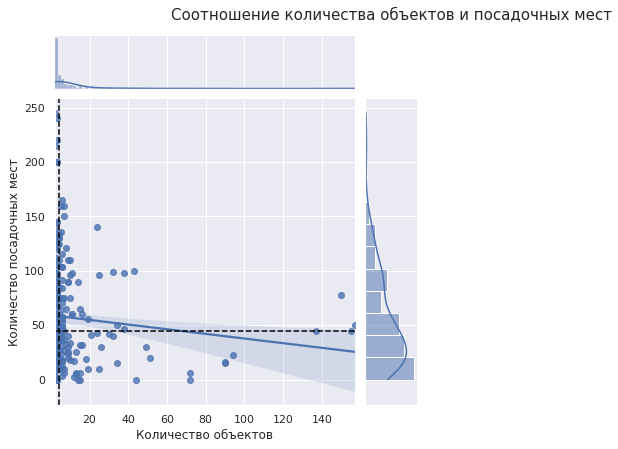

In [44]:
chain_df = rest[rest['chain'] == 'да'].groupby('object_name').agg({'object_name':'count', 'number':'median'})
chain_df.columns = ['objects', 'median_number']
chain_df = chain_df.query('objects != 1')

fig = sns.jointplot(x='objects', y='median_number', data=chain_df, kind='reg') 
sns.set(style='darkgrid')
fig.ax_joint.axvline(x=chain_df.objects.median(),color='black', linestyle='--')
fig.ax_joint.axhline(y=chain_df.median_number.median(), color='black', linestyle='--')
plt.title('Соотношение количества объектов и посадочных мест', fontsize=15, loc='center', pad=80)    
fig.set_axis_labels('Количество объектов',
                  'Количество посадочных мест')
plt.show()

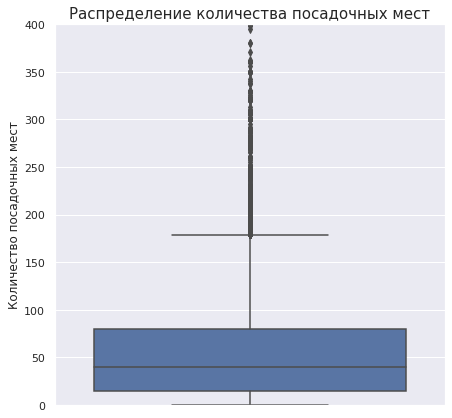

In [45]:
plt.figure(figsize=(7, 7))
ax = sns.boxplot(y='number', data=rest)
plt.ylim(0, 400)
plt.title('Распределение количества посадочных мест', fontsize=15)
plt.ylabel('Количество посадочных мест', fontsize=12)
plt.show()

На первом графике видим, что с увеличением количества объектов в сетях снижается количество посадочных мест. Так мы не видим сетей с количеством посадочных мест более 100 при количестве 44 и более объектов.

На втором графике видим общее распределение посадочных мест по всем объектам. При сравнении двух графиков видим, что количество посадочных мест в сетевых объектах ниже или около медианы. 
#### Вывод
Можем сделать вывод, что для сетевых объектов характерно много объектов с небольшим количеством посадочных мест.


### Определение количества посадочных мест для каждого вида общественного питания

Рассмотрим количество посадочных мест каждого вида объекта общественного питания. Для исключения влияния выбросов возьмём медианное значение.

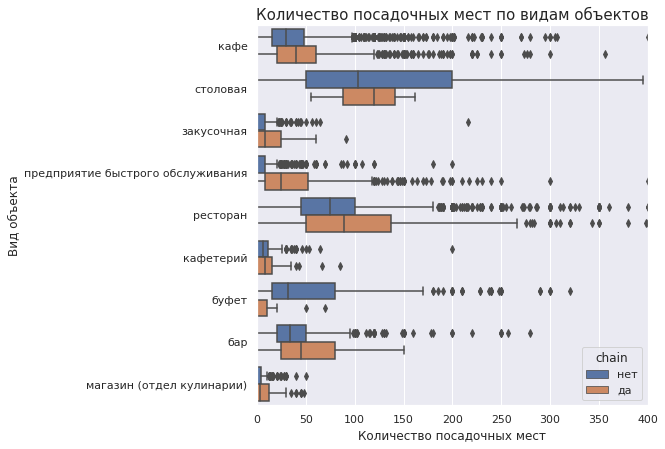

In [46]:
plt.figure(figsize=(7, 7))
ax = sns.boxplot(x='number', y='object_type', hue='chain', data=rest)
plt.xlim(0, 400)
plt.title('Количество посадочных мест по видам объектов', fontsize=15)
plt.xlabel('Количество посадочных мест', fontsize=12)
plt.ylabel('Вид объекта', fontsize=12)
plt.show()

#### Вывод
Самое большое количество посадочных мест располагается в столовых, затем по убыванию идут рестораны, бары, кафе.

В объектах одного и того же вида в сетевых заведениях медианное значение посадочных мест, как правило, выше по сравнению с несетевыми.

### Определение топ-10 улиц по количеству объектов общественного питания

Посмотрим какие улицы самые популярные для размещения объекта общественного питания.

В ходе выполнения выяснилось, что у части адресов отличается формат отображения от большинства: во-первых, не указан город; во-вторых, указано два города одновременно - Москва и Зеленоград.

В первом случае выделим из адреса улицу с учётом формата, во втором случае отфильтруем эти значения (они насчитывают 232 строки - это чуть более 1% от общих данных).

In [47]:
'''выделяем город из адреса'''
def city(row):
    split_string = row['address'].split(', ')
    row['city'] = split_string[0]
    return row['city']

rest['city'] = rest.apply(city, axis=1)

In [48]:
'''получаем улицу'''
def street(row):
    if row['city'] == 'город москва':
        split_string = row['address'].split(', ')
        row['street'] = split_string[1]
        return row['street']
    else:
        split_string2 = row['address'].split(', ')
        row['street'] = split_string2[0]
        return row['street']
    return row['street']

rest['street'] = rest.apply(street, axis=1)

In [49]:
rest_filtered = rest[(rest['street'] != 'город зеленоград') & (rest['street'] != 'поселение сосенское')].drop(labels='city', axis=1)

df = rest_filtered.groupby(['street'], as_index=False).agg(rest_number = ('object_name', 'count')).sort_values(by='rest_number', ascending=False).head(10)

bar = px.bar(df, x='street', y='rest_number', title='Топ-10 улиц по количеству объектов общественного питания')
bar.update_layout(xaxis_title='Улица',
                 yaxis_title='Количество заведений')

Первая пятерка улиц с самым большим количеством объектов общественного питания: проспект Мира - 204, Профсоюзная улица - 183, Ленинградский проспект - 173, Пресненская набережная - 167, Варшавское шоссе - 162.

Чтобы ответить на вопрос в каких районах находятся улицы с наибольшим количеством объектов общественного питания нам понадобятся дополнительные данные. После определённого поиска загружаем данные, знакомимся и подготовливаем их к дальнейшему анализу.

In [50]:
spreadsheet_id = '1Z5PAWN_TnZ7qs2uy_v7ynmXdtL20DRz807ySRUQvi2I'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
external_df = pd.read_csv(BytesIO(r.content))
external_df.head()

,ID,Name,global_id,IsNetObject,OperatingCompany,TypeObject,AdmArea,District,Address,PublicPhone,...,AdmArea_en,District_en,Address_en,PublicPhone_en,SeatsCount_en,SocialPrivileges_en,Longitude_WGS84_en,Latitude_WGS84_en,geodata_center,geoarea
0,Код,Наименование,global_id,Является сетевым,Название управляющей компании,Вид объекта,Административный округ по адресу,Район,Адрес,Контактный телефон,...,AdmArea_en,District_en,Address_en,PublicPhone_en,SeatsCount_en,SocialPrivileges_en,Longitude_WGS84_en,Latitude_WGS84_en,geodata_center,geoarea
1,00151635,СМЕТАНА,637376221,нет,NaN,кафе,Северо-Восточный административный округ,Ярославский район,"город Москва, улица Егора Абакумова, дом 9",PublicPhone:(499) 183-14-10\n\n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""coordinates"":[37.714565000436,55.87900153130...",NaN
2,000077874,Родник,637376331,нет,NaN,кафе,Центральный административный округ,Таганский район,"город Москва, улица Талалихина, дом 2/1, корпус 1",PublicPhone:(495) 676-55-35\n\n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""coordinates"":[37.6733061300344,55.7382386551...",NaN
3,000024309,Кафе «Академия»,637376349,нет,NaN,ресторан,Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",PublicPhone:(495) 662-30-10\n\n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000027429,ГБОУ «Школа № 1430 имени Героя Социалистическо...,637376480,нет,NaN,столовая,Северо-Восточный административный округ,район Лианозово,"город Москва, Угличская улица, дом 17",PublicPhone:(499) 908-06-15\n\n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""coordinates"":[37.56694,55.9040188006692],""ty...",NaN


In [51]:
external_df.columns = external_df.columns.str.lower()
external_df = external_df.rename(columns={'name':'object_name'})

external_df = external_df[['object_name', 'address', 'district']]

external_df = external_df.drop(labels=[0], axis=0)

for column in ['object_name', 'address', 'district']:
    external_df[column] = external_df[column].str.lower()

external_df.head()

,object_name,address,district
1,сметана,"город москва, улица егора абакумова, дом 9",ярославский район
2,родник,"город москва, улица талалихина, дом 2/1, корпус 1",таганский район
3,кафе «академия»,"российская федерация, город москва, внутригоро...",таганский район
4,гбоу «школа № 1430 имени героя социалистическо...,"город москва, угличская улица, дом 17",район лианозово
5,брусника,"город москва, переулок сивцев вражек, дом 6/2",район арбат


Проверим какие значения попали в столбец 'city' после обработки функцией.

In [52]:
external_df['city'] = external_df.apply(city, axis=1)
external_df['city'].value_counts().head()

город москва               15182
российская федерация        2484
москва                        29
николоямская улица             3
улица ленинская слобода        3
Name: city, dtype: int64

Здесь также видим, что в столбце 'address' различается формат отображения адреса. Вероятно при ручном вводе данных не все следовали рекомендуемому образцу, либо ошибки при изменении типа файла при загрузке или выгрузке. Немного доработаем ранее написанную функцию для получения отдельного названия улицы.

In [53]:
'''получаем улицу'''
def street(row):
    if row['city'] == 'город москва' or row['city'] == 'москва':
        split_string = row['address'].split(', ')
        row['street'] = split_string[1]
        return row['street']
    elif row['city'] == 'российская федерация':
        split_string2 = row['address'].split(', ')
        row['street'] = split_string2[3]
        return row['street']
    else:
        split_string3 = row['address'].split(', ')
        row['street'] = split_string3[0]
        return row['street']
    return row['street']

external_df['street'] = external_df.apply(street, axis=1)

external_df.head()

,object_name,address,district,city,street
1,сметана,"город москва, улица егора абакумова, дом 9",ярославский район,город москва,улица егора абакумова
2,родник,"город москва, улица талалихина, дом 2/1, корпус 1",таганский район,город москва,улица талалихина
3,кафе «академия»,"российская федерация, город москва, внутригоро...",таганский район,российская федерация,абельмановская улица
4,гбоу «школа № 1430 имени героя социалистическо...,"город москва, угличская улица, дом 17",район лианозово,город москва,угличская улица
5,брусника,"город москва, переулок сивцев вражек, дом 6/2",район арбат,город москва,переулок сивцев вражек


Фильтруем внешний датафрейм по списку популярных улиц и объединяем его по улице и названию объекта на ней с исходным датафреймом, также отфильтрованным по списку топ-10 улиц. 

In [54]:
street_filter = list(df['street']) # топ-10 улиц

external_df_filtered = external_df.query('street == @street_filter')

rest_merged = rest_filtered.query('street == @street_filter').merge(external_df_filtered[['object_name', 'street', 'district']], left_on=['object_name', 'street'], right_on=['object_name', 'street'], how='left')
rest_merged.head()

,index,object_name,chain,object_type,address,number,street,district
0,151,кафе «андерсон»,да,кафе,"город москва, варшавское шоссе, дом 2",150,варшавское шоссе,NaN
1,152,кафе «subway»,да,кафе,"город москва, варшавское шоссе, дом 7, корпус 1",36,варшавское шоссе,NaN
2,153,кафе «ламаджо»,нет,кафе,"город москва, варшавское шоссе, дом 29",30,варшавское шоссе,донской район
3,154,шаурма в пите,нет,предприятие быстрого обслуживания,"город москва, варшавское шоссе, дом 72, корпус 2",0,варшавское шоссе,NaN
4,155,выпечка,нет,кафетерий,"город москва, варшавское шоссе, дом 100",2,варшавское шоссе,NaN


Пропуски в районах заполним модой исходя из улицы.

In [55]:
def my_mode(s): 
    mode = s.mode()
    if len(mode) > 0:
        return mode[0]
 
new_district = rest_merged.groupby('street')['district'].transform(my_mode)
rest_merged['district'] = rest_merged['district'].fillna(new_district)

In [56]:
rest_merged['district'].isna().sum()

0

In [57]:
rest_merged['district'].unique()

array(['нагорный район', 'донской район', 'район тропарёво-никулино',
       'ломоносовский район', 'район дорогомилово',
       'район москворечье-сабурово', 'район чертаново центральное',
       'район аэропорт', 'район беговой', 'район сокол',
       'хорошёвский район', 'район якиманка', 'гагаринский район',
       'обручевский район', 'мещанский район', 'останкинский район',
       'алексеевский район', 'район ясенево', 'академический район',
       'район коньково', 'район черёмушки', 'район тёплый стан',
       'район орехово-борисово южное', 'район чертаново южное',
       'район чертаново северное', 'район проспект вернадского',
       'район раменки', 'район нагатино-садовники', 'район свиблово',
       'район фили-давыдково', 'поселение вороновское', 'район ростокино',
       'район южное бутово', 'поселение краснопахорское',
       'район орехово-борисово северное', 'пресненский район'],
      dtype=object)

Так как некоторые улицы очень длинные, они проходят через несколько районов, отсюда и довольно большой список.

In [58]:
str_distr_grouped = rest_merged.groupby(['street', 'district'], as_index=False).agg(object_number = ('object_name','count'))

str_grouped = str_distr_grouped.groupby(['street'], as_index=False)['object_number'].max()

str_merged = pd.merge(str_grouped, str_distr_grouped, on=['street', 'object_number'], how='left')
str_merged[['district', 'street']]

,district,street
0,нагорный район,варшавское шоссе
1,район москворечье-сабурово,каширское шоссе
2,район чертаново центральное,кировоградская улица
3,район дорогомилово,кутузовский проспект
4,район аэропорт,ленинградский проспект
5,обручевский район,ленинский проспект
6,пресненский район,пресненская набережная
7,район тропарёво-никулино,проспект вернадского
8,мещанский район,проспект мира
9,район коньково,профсоюзная улица


In [59]:
# немного изменим функцию
def px_bar(df, column):
    df2 = df.groupby([column], as_index=False).agg(quantity = ('address', 'count')).sort_values(by='quantity', ascending=False).head(10)
    bar = px.bar(df2, x=column, y='quantity', title='Топ-10 районов по количеству объектов общественного питания')
    bar.update_layout(xaxis_title='Район',
                     yaxis_title='Количество') 
    return bar

px_bar(rest_merged, 'district')

Четыре района имеют чуть большие показатели, чем остальные: Мещанский, Пресненский, Тропарёво-Никулино, Аэропорт (от 168 до 185).
#### Вывод
Определили топ-10 улиц по количеству объектов питания на них. Первые пять из них: проспект Мира - 204, Профсоюзная улица - 183, Ленинградский проспект - 173, Пресненская набережная - 167, Варшавское шоссе - 162.

Определили районы, в которых находятся эти улицы. Четыре района с самым большим количеством объектов общественного питания: Мещанский - 185, Пресненский - 182, Тропарёво-Никулино - 179, Аэропорт - 168.

### Определение улиц с одним объектом общественного питания
Теперь посмотрим на улицы где находится только один объект общественного питания.

In [60]:
min_rest_number = rest_filtered.groupby(['street'], as_index=False).agg(rest_number = ('object_name', 'count'))
print('Количество улиц с одним объектом общественного питания: {0}'.format(len(min_rest_number[min_rest_number['rest_number'] == 1])))

Количество улиц с одним объектом общественного питания: 541


In [61]:
min_street_filter = list(min_rest_number[min_rest_number['rest_number'] == 1]['street'])

external_df_obj_min = external_df.query('street == @min_street_filter')
print('Количество районов с улицами на которых располагается только один объект общественного питания: {0}'.format(len(external_df_obj_min['district'].unique())))

def px_bar(df, column):
    df2 = df.groupby([column], as_index=False).agg(quantity = ('address', 'count')).sort_values(by='quantity', ascending=False).head(10)
    bar = px.bar(df2, x=column, y='quantity', title='Топ-10 районов по количеству улиц с 1 объектом общественного питания')
    bar.update_layout(xaxis_title='Район',
                     yaxis_title='Количество улиц') 
    return bar

px_bar(external_df_obj_min, 'district')

Количество районов с улицами на которых располагается только один объект общественного питания: 99


#### Вывод
541 улица Москвы имеет только один объект общественного питания.

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

Посмотрим как распределяются посадочные места в заведениях на топ-10 популярных улиц.

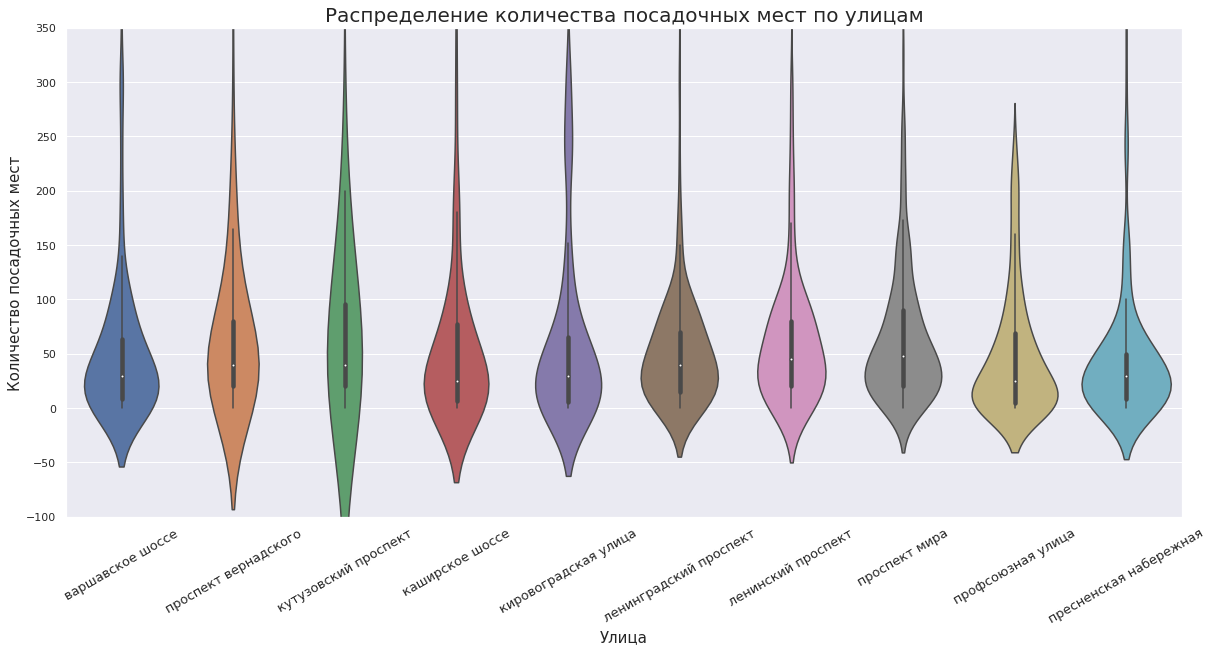

In [62]:
top_street_rests = rest_filtered.query('street == @street_filter')

plt.figure(figsize=(20, 9))
sns.violinplot(x='street', y='number', data=top_street_rests)
plt.ylim(-100,350)
plt.title('Распределение количества посадочных мест по улицам', fontsize=20)
plt.ylabel('Количество посадочных мест', fontsize=15)
plt.xlabel('Улица', fontsize=15)
plt.xticks(rotation=30, fontsize=13)
plt.show()

По графику можно выделить следующие общие моменты: 
- медианное значение посадочных мест относительно небольшое и варьируется от 25 до 50;
- в 75% заведений на всех улицах количество посадочных мест не превышает 100 штук.

Посмотрим какой вид объектов общественного питания преобладает на этих улицах.

In [63]:
top_street_rests_grouped = top_street_rests.groupby(['street', 'object_type'], as_index=False).agg(rest_number =('object_name','count'))
top_street_rests_grouped
obj = top_street_rests_grouped.groupby(['street'], as_index=False)['rest_number'].max()
obj_merge = pd.merge(obj, top_street_rests_grouped, on=['street', 'rest_number'], how='left')
obj_merge

,street,rest_number,object_type
0,варшавское шоссе,63,кафе
1,каширское шоссе,42,предприятие быстрого обслуживания
2,кировоградская улица,46,предприятие быстрого обслуживания
3,кутузовский проспект,48,ресторан
4,ленинградский проспект,70,кафе
5,ленинский проспект,64,кафе
6,пресненская набережная,98,кафе
7,проспект вернадского,55,кафе
8,проспект мира,103,кафе
9,профсоюзная улица,90,кафе


Также как и в целом по городу кафе более распространённый вид объекта общественного питания, но есть и исключения. 
#### Вывод
- медианное значение посадочных мест относительно небольшое и варьируется от 25 до 50;
- в 75% заведений на всех улицах количество посадочных мест не превышает 100 штук.

Такие значения характерны для небольших заведений. Дальнейшая группировка также подтверждает этот вывод. На этих улицах кафе является наиболее распространённым видом объекта общественного питания.

## Вывод

В процессе выполнения провели следующие действия:
- загрузили данные, ознакомились с ними
- рассмотрели объекты общественного питания по видам
- определили характерные черты сетевых заведений
- определили количество посадочных мест для всех видов объектов общественного питания
- рассмотрели местонахождение объектов на территории Москвы.

Нами установлено: 
- большую часть рынка занимают кафе - 40%
- сетевые заведения составляют только 20% от общего количества
- сетевое распространение характерно для предприятий быстрого обслуживания
- для сетевых объектов характерно много объектов с небольшим количеством посадочных мест
- самое большое количество посадочных мест располагается в столовых, затем по убыванию идут рестораны, бары, кафе
- в сетевых заведениях медианное значение посадочных мест, как правило, выше по сравнению с несетевыми
- улицы с самым большим количеством объектов общественного питания: проспект Мира - 204, Профсоюзная улица - 183, Ленинградский проспект - 173, Пресненская набережная - 167, Варшавское шоссе - 162
- районы с самым большим количеством объектов общественного питания: Мещанский - 185, Пресненский - 182, Тропарёво-Никулино - 179, Аэропорт - 168
- есть улицы с одним объектом общественного питания. Их количество 541, располагаются они в 99 районах
- на улицах с самым большим количеством объектов общественного питания преобладают небольшие заведения с медианным значением посадочных мест от 25 до 50, в 75% заведений количество посадочных мест не превышает 100 штук.

Рекомендации:
Если брать во внимание намерение открыть небольшое заведение, то стоит рассмотреть форматы кафе и предприятие быстрого обслуживания. Но в заведениях фастфуда, как правило, нет официантов, тогда формат кафе будет более предпочтительным (самый популярный формат в городе). 

Оптимальным количеством посадочных мест будет от 25 до 50.

За основу выбора расположения заведения можно взять районы с самым большим количеством объектов общественного питания: Мещанский, Пресненский, Тропарёво-Никулино, Аэропорт. Каждый из которых имеет свои плюсы.

Мещанский район - большое количество исторических зданий, культурных сооружений, СК "Олимпийский" всё это привлекает много жителей и гостей города.

Пресненский район - хорошо известен благодаря бизнес-центру "Москва-Сити", также на территории района располагается Московский зоопарк. Помимо деловых кругов привлекает много туристического трафика.

Тропарёво-Никулино - это большой массив жилых домов и административных зданий, пользуется репутацией интеллектуального и научного центра. Характерная черта района — учреждения науки. Здесь находятся 6 высших учебных заведений, из них 3 академии. Молодые люди охотнее принимают и используют новые веяния.

Район Аэропорт развивался как район для жизни и учёбы, поэтому здесь расположено несколько высших учебных заведений и студенческих общежитий. На первый взгляд схож с предыдущим районом в плане его контингента.

В случае развития сети небольшое заведение предоставляет больше возможностей при выборе площадки для нового заведения. И при стабильной популярности можно относительно легко масштабировать сеть. Что мы и увидели в исследовании, крупные сети имеют заведения с количеством посадочных мест близким к медианному или даже ниже его. В рекомендациях указано медианные значения в зависимости от района.

Презентация: https://drive.google.com/file/d/1uQMoEMa6zSkxeqLn-MV9Fy7ixHAm19p2/view?usp=sharing